In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
import warnings
from tqdm import tqdm
import re
import random


# Example usage:
from invasion import (
    compute_nontrivial_slice,
    simulate_segment,
    compute_deltaW_curve,
    compare_severities,
    test_plot,
    compare_scalers,
    run_cycles,
    run_cycles_ext,
    simulate_segment2,
    run_invasion,
    pairwise_invasion_plot,
    piplot,
    local_invasibility_heatmap,
    local_invasibility_path,
    test_invasion,
)

W_birth = 0.4
W_death = 0.1
Y_birth = 0.9
Y_death = 0.15

X_in = 0.1
X_out = 0.1
Z_in = 0.5
Z_out = 0.25

Time = 600.0
dt = 0.1

use_X = True
use_Z = False

num_points = 100
severity = 0.5
cycles = 4000
extinction_rate = 50
U_out = 0.05
U_in = U_out
X_out = 0.06
X_in = X_out

W,Y = compute_nontrivial_slice(W_birth, W_death, Y_birth, Y_death)
W0 = W/2
X0 = W0 / (X_out / X_in)
V0 = W - W0
U0 = V0 / (U_out / U_in)
Y0 = Y
Z0 = Y0/ (Z_out /Z_in)
dt = 0.1

In [2]:


def local_invasibility_path(
    V0, W0, Y0, 
    W_birth, Y_birth, W_death, Y_death,
    Z_in, Z_out,
    extinction_rate, dt,
    use_X, use_Z,
    cycles, severity,
    grid_size=5,
    U_in_min=0.01, U_in_max=0.4,
    U_out_min=0.01, U_out_max=0.4,
    folder='total_invasibility',
):
    """
    For each interior gridpoint (i,j) on [0,1]^2 in U_in, X_in:
      • Evaluate run_invasion at its 8 nearest neighbors
      • Compute mean of their np.sign(deltaW)
      • Plot that in grayscale (1=black…+1=white)
    """

    # 1) Prepare output directory
    os.makedirs(folder, exist_ok=True)

    # 2) Build the [0,1] grid
    U_in_vals = np.linspace(U_in_min, U_in_max, grid_size)
    U_out_vals = np.linspace(U_out_min, U_out_max, grid_size)

    # 3) Initialize the score matrix
    score = np.zeros((grid_size, grid_size))

    # 4) Offsets for the eight neighbors
    neighbor_offsets = [         (1,0),       
                        ( 0,1),         ( 0,-1),
                                 ( -1,0),       ]
    deltas = {}

    steps = 0

    current = (1, 1)
    path_coords = []


    while steps < grid_size:
        steps += 1
        i, j = current
        path_coords.append((U_in_vals[i], U_out_vals[j]))
        shuffeled_offsets = neighbor_offsets.copy()
        random.shuffle(shuffeled_offsets)
        for di, dj in shuffeled_offsets:
                X_in = U_in_vals[i+di]
                X_out = U_out_vals[j+dj]

                if ((i+di,j+dj), (i,j)) in deltas.keys():
                    if deltas[((i+di,j+dj), (i,j))] == 0:
        
                        current = (di, dj)
                        continue
                    else:
                        continue   
                else:
                    deltaW = run_invasion(

                         V0=V0, W0=W0, Y0=Y0,
                        W_birth=W_birth, Y_birth=Y_birth,
                        W_death=W_death, Y_death=Y_death,
                        X_in=X_in, X_out=X_out,
                        U_in=U_in_vals[i],U_out=U_in_vals[j],
                        Z_in=Z_in, Z_out=Z_out,
                        extinction_rate=extinction_rate, dt=dt,
                        use_X=use_X, use_Z=use_Z,
                        cycles=cycles, severity=severity,
                        perturb_W=False, perturb_Y=True,
                        plot=False,

    
                    )
                    if deltaW> 0:
                        deltas[((i,j), (i+di,j+dj))] = 1
                        deltas[((i+di,j+dj), (i,j))] = 0
                        current = (di, dj)
                        continue
                    else:
                        deltas[((i,j), (i+di,j+dj))] = 0
                        deltas[((i+di,j+dj), (i,j))] = 1
                       

    return U_in_vals, U_out_vals, deltas, path_coords




In [3]:
local_invasibility_path(
    V0, W0, Y0,
    W_birth, Y_birth, W_death, Y_death,
    Z_in, Z_out,
    extinction_rate, dt,
    use_X, use_Z,
    cycles, severity,
    grid_size=50,
    U_in_min  = 0.01,
    U_in_max  = 0.5, 
    U_out_min  = 0.01, 
    U_out_max  = 0.5

)

(array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
        0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
        0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
        0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
 array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
        0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
        0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
        0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
        0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ]),
 {((1, 1), (2, 1)): 1,
  ((2, 1), (1, 1)): 0,
  ((1, 1), (0, 1)): 0,
  ((0, 1), (1, 1)): 1,
  ((1, 1), (1, 2)): 0,
  ((1, 2), (1, 1)): 1,
  ((1, 1), (1, 0)): 1,
  ((1, 0), (1, 1)): 0,
  ((0, -1), (1, -1)): 1,
  ((1, -1), (0, -1)): 0,
  ((0, -1), (0, 0)): 1,
  ((0, 0), (0, -1)): 0,
  ((0, -1), (0, -2)): 1,
  ((0, -2

Computing local invasibility: 100%|██████████| 78/78 [15:52:29<00:00, 732.68s/it]   


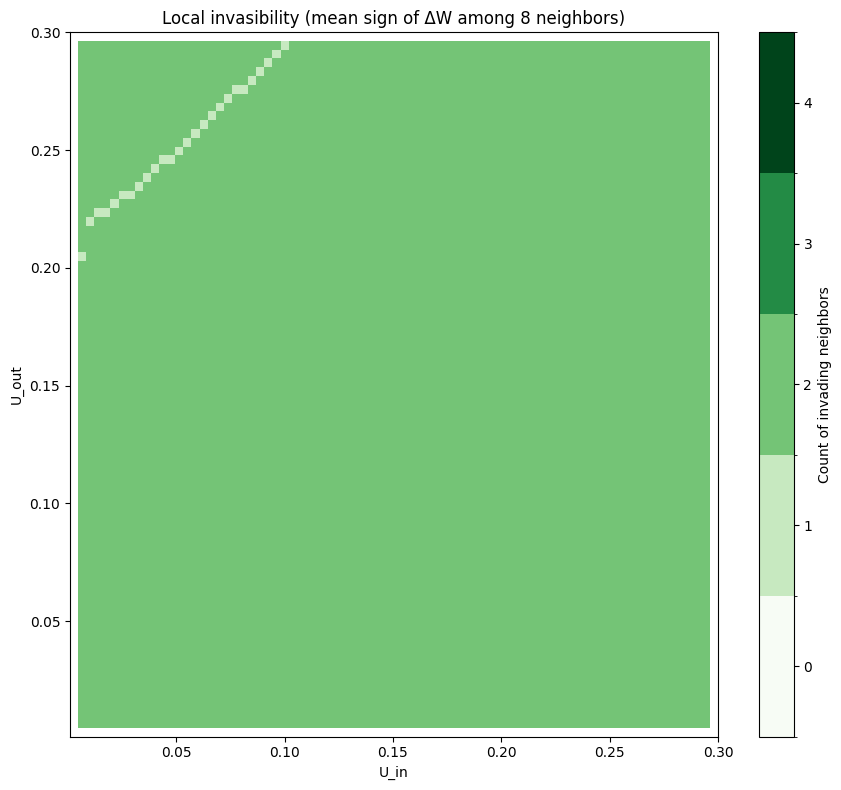

In [21]:
x = local_invasibility_heatmap(
    V0, W0, Y0,
    W_birth, Y_birth, W_death, Y_death,
    Z_in, Z_out,
    extinction_rate, dt,
    use_X, use_Z,
    cycles, severity,
    grid_size=80,
    U_in_min  = 0.001,
    U_in_max  = 0.3, 
    U_out_min  = 0.001, 
    U_out_max  = 0.3

)

In [25]:
helper = x[3]

In [34]:
helper

{((1, 1), (0, 1)): -1,
 ((0, 1), (1, 1)): 1,
 ((1, 1), (1, 0)): 1,
 ((1, 0), (1, 1)): -1,
 ((1, 1), (1, 2)): -1,
 ((1, 2), (1, 1)): 1,
 ((1, 1), (2, 1)): 1,
 ((2, 1), (1, 1)): -1,
 ((1, 2), (0, 2)): -1,
 ((0, 2), (1, 2)): 1,
 ((1, 2), (1, 3)): -1,
 ((1, 3), (1, 2)): 1,
 ((1, 2), (2, 2)): 1,
 ((2, 2), (1, 2)): -1,
 ((1, 3), (0, 3)): -1,
 ((0, 3), (1, 3)): 1,
 ((1, 3), (1, 4)): -1,
 ((1, 4), (1, 3)): 1,
 ((1, 3), (2, 3)): 1,
 ((2, 3), (1, 3)): -1,
 ((1, 4), (0, 4)): -1,
 ((0, 4), (1, 4)): 1,
 ((1, 4), (1, 5)): -1,
 ((1, 5), (1, 4)): 1,
 ((1, 4), (2, 4)): 1,
 ((2, 4), (1, 4)): -1,
 ((1, 5), (0, 5)): -1,
 ((0, 5), (1, 5)): 1,
 ((1, 5), (1, 6)): -1,
 ((1, 6), (1, 5)): 1,
 ((1, 5), (2, 5)): 1,
 ((2, 5), (1, 5)): -1,
 ((1, 6), (0, 6)): -1,
 ((0, 6), (1, 6)): 1,
 ((1, 6), (1, 7)): -1,
 ((1, 7), (1, 6)): 1,
 ((1, 6), (2, 6)): 1,
 ((2, 6), (1, 6)): -1,
 ((1, 7), (0, 7)): -1,
 ((0, 7), (1, 7)): 1,
 ((1, 7), (1, 8)): -1,
 ((1, 8), (1, 7)): 1,
 ((1, 7), (2, 7)): 1,
 ((2, 7), (1, 7)): -1,
 ((1, 8), 

In [26]:
helper2 = helper.copy()

In [37]:
# %% [markdown]
# # Persisting and Reloading a Tuple-Key Dictionary via Pickle
# This notebook demonstrates how to save a dictionary whose keys are nested tuples
# and then load it back, verifying data integrity.

# %% 
import pickle
from pathlib import Path
from typing import Any, Union

# %% 
# 1) Define the dictionary with tuple-of-tuples keys

# %% 
def save_dict_as_pickle(
    d: dict,
    filename: str,
    protocol: int = pickle.HIGHEST_PROTOCOL
) -> None:
    """
    Serialize the dictionary `d` to a pickle file at `filename`.

    Parameters
    ----------
    d : dict
        Dictionary to serialize.
    filename : str
        Destination file path (e.g. 'helper.pkl').
    protocol : int, optional
        Pickle protocol to use (defaults to HIGHEST_PROTOCOL).
    """
    target = Path(filename)
    with target.open("wb") as f:
        pickle.dump(d, f, protocol=protocol)
    print(f"Dictionary successfully saved to '{filename}'.")

# %% 
# 2) Save the `helper` dict
save_dict_as_pickle(helper, "helper.pkl")

# %% 
def load_pickle_file(path: Union[Path, str]) -> Any:
    """
    Load and return the Python object stored in a pickle file.

    Parameters
    ----------
    path : pathlib.Path or str
        Path to the pickle file to load.

    Returns
    -------
    object
        The deserialized Python object.

    Raises
    ------
    FileNotFoundError
        If the specified file does not exist.
    pickle.UnpicklingError
        If the file is not a valid pickle or is corrupted.
    """
    file_path = Path(path)
    if not file_path.is_file():
        raise FileNotFoundError(f"Pickle file not found: {file_path!r}")

    with file_path.open("rb") as f:
        try:
            obj = pickle.load(f)
        except pickle.UnpicklingError as e:
            raise pickle.UnpicklingError(
                f"Failed to unpickle file {file_path!r}: {e}"
            )
    return obj

# %% 
# 3) Load and verify
loaded_helper = load_pickle_file("helper.pkl")
print("\nReloaded object type:", type(loaded_helper).__name__)
print("Number of entries:", len(loaded_helper))

# Verify integrity
assert loaded_helper == helper, "Loaded dictionary does not match the original!"
print("Integrity check passed: loaded dictionary is identical to the original.")

Dictionary successfully saved to 'helper.pkl'.

Reloaded object type: dict
Number of entries: 24648
Integrity check passed: loaded dictionary is identical to the original.


In [39]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
import os

def reconstruct_from_signs_heatmap_filled(signs, N, folder='surface'):
    """
    Reconstruct f as before, then plot filled contours (constant color bands)
    and overlay contour lines.  This guarantees that along each contour line,
    the color on either side is uniform.
    """
    os.makedirs(folder, exist_ok=True)
    M = N*N
    rows, cols, data = [], [], []
    g = np.zeros(M)
    idx = lambda i,j: i*N + j

    # (Reconstruction of f_vec exactly as before…)
    offsets = [(1,0),(-1,0),(0,1),(0,-1)]
    for i in range(N):
        for j in range(N):
            n = idx(i,j)
            deg = 0
            for di, dj in offsets:
                ii, jj = i+di, j+dj
                if 0 <= ii < N and 0 <= jj < N:
                    deg += 1
                    rows.append(n); cols.append(idx(ii,jj)); data.append(-1)
                    g[n] += signs.get(((i,j),(ii,jj)), 0)
            rows.append(n); cols.append(n); data.append(deg)

    L = sp.coo_matrix((data,(rows,cols)),shape=(M,M)).tocsr()
    L[0,:] = 0; L[0,0] = 1
    g[0] = 0
    f_vec = spla.spsolve(L, g)
    f = f_vec.reshape((N,N))

    # Optionally flip: f = -f

    # Prepare coordinates
    x = np.linspace(0,1,N)
    y = np.linspace(0,1,N)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Choose contour levels
    levels = np.linspace(f.min(), f.max(), 11)

    # Plot
    fig, ax = plt.subplots(figsize=(6,5))
    # 1) filled contours with discrete bands
    cf = ax.contourf(
        X, Y, f,
        levels=levels,
        cmap='viridis',
        extend='both'
    )
    cbar = fig.colorbar(cf, ax=ax)
    cbar.set_label('Reconstructed f')

    # 2) contour lines on top
    cs = ax.contour(
        X, Y, f,
        levels=levels,
        colors='white',
        linewidths=1
    )
    ax.clabel(cs, fmt='%.2f', colors='white', fontsize=8)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Reconstructed Surface (filled contours)')
    plt.tight_layout()

    outpath = os.path.join(folder, 'reconstructed_filled_contours.pdf')
    fig.savefig(outpath)
    plt.show()
    print(f"Saved filled‐contour plot to {outpath}")

    return f

In [40]:
signs = x[3]

In [7]:
len(signs)/4

342.0

/Users/xaverwangerpohl/anaconda3/envs/dreiAcht/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


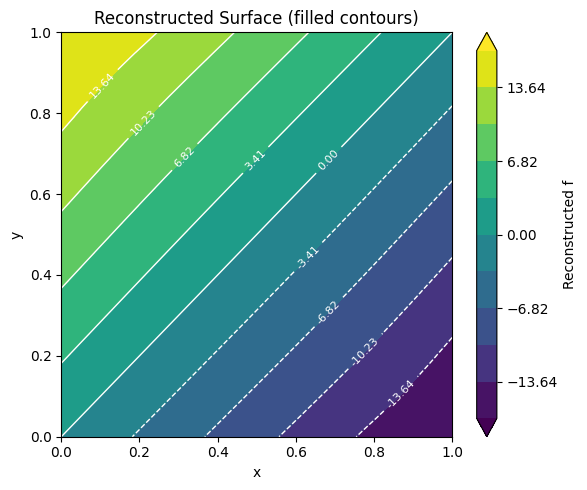

Saved filled‐contour plot to surface/reconstructed_filled_contours.pdf


array([[ 0.00000000e+00,  9.94511870e-01,  1.98353561e+00,
         2.96706620e+00,  3.94508358e+00,  4.91753746e+00,
         5.88432667e+00,  6.84527188e+00,  7.80007952e+00,
         8.74829293e+00,  9.68922301e+00,  1.06218447e+01,
         1.15446334e+01,  1.24552896e+01,  1.33502419e+01,
         1.42236776e+01,  1.50654632e+01,  1.58561864e+01,
         1.65538672e+01,  1.70538672e+01],
       [-9.94511870e-01, -8.25728375e-16,  9.89028757e-01,
         1.97257942e+00,  2.95064707e+00,  3.92320213e+00,
         4.89017069e+00,  5.85140944e+00,  6.80667374e+00,
         7.75557626e+00,  8.69753138e+00,  9.63167770e+00,
         1.05567660e+01,  1.14709934e+01,  1.23717586e+01,
         1.32553277e+01,  1.41165255e+01,  1.49492289e+01,
         1.57515480e+01,  1.65538672e+01],
       [-1.98353561e+00, -9.89028757e-01, -9.99200722e-16,
         9.83575645e-01,  1.96172316e+00,  2.93445329e+00,
         3.90174451e+00,  4.86352144e+00,  5.81962976e+00,
         6.76980700e+00,  7.7

In [41]:
reconstruct_from_signs_heatmap_filled(
    signs, N=20, folder='surface'
)

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_single_invasion_directions(
    deltas,
    U_in_vals, U_out_vals,
    grid_size,
    folder='total_invasibility'
):
    """
    From deltas[((i,j),(k,l))]=1 (neighbour (k,l) invades (i,j)),
    select only *interior* points with exactly one invading neighbour,
    and plot an arrow indicating the invasion direction on the same
    coordinate system and orientation as the heatmap.

    Saves a PDF to `folder` and displays the figure.
    """
    os.makedirs(folder, exist_ok=True)

    # Gather invasion directions for interior points
    inv_dirs = {}
    for (src, dst), val in deltas.items():
        if val != 1:
            continue
        i, j = src  # i index in U_in_vals, j index in U_out_vals
        # exclude border
        if not (0 < i < grid_size-1 and 0 < j < grid_size-1):
            continue
        k, l = dst
        inv_dirs.setdefault(src, []).append((k - i, l - j))

    # Keep only those with exactly one invading neighbour
    single_dirs = {src: dirs[0] for src, dirs in inv_dirs.items() if len(dirs) == 1}
    if not single_dirs:
        print("No interior points with exactly one invading neighbour.")
        return

    # Build arrays for quiver: match imshow's extent/orientation
    Xs, Ys, Us, Vs = [], [], [], []
    for (i, j), (di, dj) in single_dirs.items():
        # x coordinate = U_in_vals[j], y = U_out_vals[i]
        x0 = U_in_vals[j]
        y0 = U_out_vals[i]
        # destination indices (k,l)
        k = i + di
        l = j + dj
        # dx along x-axis = change in U_in_vals: j->l
        dx = U_in_vals[l] - U_in_vals[j]
        # dy along y-axis = change in U_out_vals: i->k
        dy = U_out_vals[k] - U_out_vals[i]
        Xs.append(x0)
        Ys.append(y0)
        Us.append(dx)
        Vs.append(dy)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    # scatter all interior grid points to match heatmap layout
    # imshow places score[i,j] at (x=U_in_vals[j], y=U_out_vals[i])
    xx = np.repeat(U_in_vals, len(U_out_vals))
    yy = np.tile(U_out_vals, len(U_in_vals))
    ax.scatter(xx, yy, color='lightgray', marker='s', label='Grid points')

    # quiver arrows
    ax.quiver(
        Xs, Ys, Us, Vs,
        angles='xy', scale_units='xy', scale=1,
        color='red', width=0.005,
        label='Single-neighbour invasion'
    )

    ax.set_aspect('auto')
    ax.set_xlim(U_in_vals.min() - 0.01, U_in_vals.max() + 0.01)
    ax.set_ylim(U_out_vals.min() - 0.01, U_out_vals.max() + 0.01)
    ax.set_xlabel('U_in')
    ax.set_ylabel('U_out')
    ax.set_title('Direction of Single-Neighbour Invasions')
    ax.legend(loc='upper left')
    plt.tight_layout()

    # Save and display
    outpath = os.path.join(folder, 'single_invasion_directions.pdf')
    fig.savefig(outpath)
    plt.show()
    print(f"Saved invasion-direction plot to {outpath}")

    return


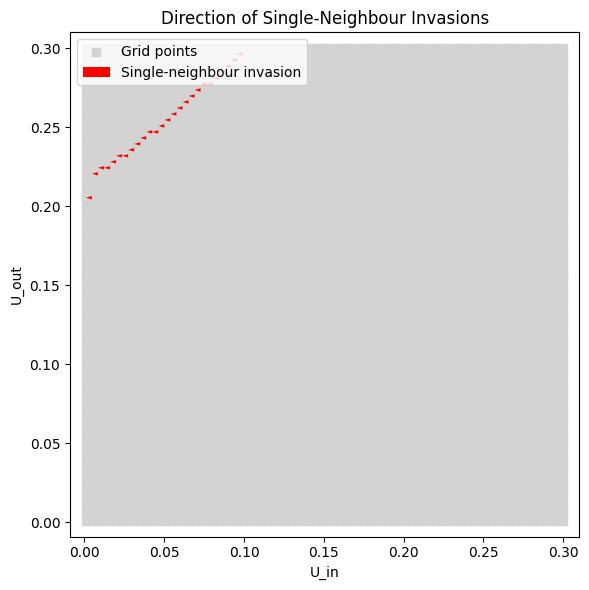

Saved invasion-direction plot to total_invasibility/single_invasion_directions.pdf


In [43]:
plot_single_invasion_directions(
    x[3],
    x[0], x[1], len(x[0]),)

In [6]:

i0, j0 = 6, 2  # example source indices

sub_deltas = {
    (k, l): v
    for ((i, j), (k, l)), v in x[3].items()
    if (i == i0 and j == j0)
}
sub_deltas

{(5, 2): -1, (6, 1): 1, (6, 3): -1, (7, 2): -1}

In [ ]:


def run_invasion(V0, W0, Y0,
               W_birth, Y_birth,
               W_death, Y_death,
               X_in, X_out,
               U_in, U_out,
               Z_in, Z_out,
               extinction_rate, dt,
               use_X, use_Z,
               severity,
               cycles=10000,
               perturb_W=False,
               perturb_Y=False,
               plot=False,
               stop=None,
               break_threshold=0.01):
    """
    Run 'cycles' successive calls to simulate_segment, each time:
      1) simulate_segment(...) → (t, V_arr, W_arr, Y_arr, X_arr, Z_arr)
      2) record final V, W, Y
      3) if perturb_W: set W0_next = (1-severity)*W_final and
                         V0_next = (1-severity)*V_final
      4) if perturb_Y: set Y0_next = (1-severity)*Y_final
      5) X0_next = X_final, Z0_next = Z_final
    After all cycles, plot cycle index vs final W, V, and Y.
    Returns lists of final values [V_finals, W_finals, Y_finals].

    """
    X0 = W0 / (X_out / X_in)
    U0 = V0 / (U_out / U_in)
    Z0 = Y0 / (Z_out /Z_in)
    V_curr, W_curr, Y_curr, X_curr, Z_curr, U_curr = V0, W0, Y0, X0, Z0, U0
    V_finals = []
    W_finals = []
    Y_finals = []

    for n in range(1, cycles+1):

        # 1) simulate one segment
        t_arr, V_arr, W_arr, Y_arr, X_arr, Z_arr, U_arr, X_plot, Z_plot, U_plot = simulate_segment2(
            V0=V_curr, W0=W_curr, Y0=Y_curr, X0=X_curr, Z0=Z_curr, U0=U_curr,
            W_birth=W_birth, Y_birth=Y_birth, W_death=W_death, Y_death=Y_death,
            X_in=X_in, Z_in=Z_in, X_out=X_out, Z_out=Z_out, U_in=U_in, U_out=U_out,
            duration=extinction_rate, dt=dt,
            use_X=use_X, use_Z=use_Z,
            tol=1e-7,
            stop_at_eq=True
        )


        # 2) record finals
        V_final = V_arr[-1]
        W_final = W_arr[-1]
        Y_final = Y_arr[-1]
        V_finals.append(V_final)
        W_finals.append(W_final)
        Y_finals.append(Y_final)

        if n == 50:
            W0 = W_final
        
        if (abs(W_final - W0) > break_threshold) and n > 50:
            break

        # 3) perturb for next cycle
        if perturb_W:
            V_curr = (1 - severity) * V_final
            W_curr = (1 - severity) * W_final
        else:
            V_curr = V_final
            W_curr = W_final

        if perturb_Y:
            Y_curr = (1 - severity) * Y_final
        else:
            Y_curr = Y_final

        # 4) carry over X, Z unchanged
        X_curr = X_arr[-1]
        Z_curr = Z_arr[-1]
        U_curr = U_arr[-1]


    if plot:

        # plot all three on one figure
        cycles_idx = np.arange(1, n+1)
        plt.figure(figsize=(8, 5))
        plt.plot(cycles_idx, W_finals, label='W final', color='darkgreen')
        plt.plot(cycles_idx, V_finals, label='V final', color='orange')
        plt.plot(cycles_idx, Y_finals, label='Y final', color='darkblue')
        plt.xlabel('Cycle', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        titlestr = f'V, W, Y after each cycle\n(severity={severity}' 
        titlestr += ', W Perturbed, ' if perturb_W else ''
        titlestr += ', Y perturbed, ' if perturb_Y else ''
        titlestr += 'U[in,out]: ({:.2f}, {:.2f}), X:({:.2f}, {:.2f}))'.format(
            U_in, U_out, X_in, X_out)
        plt.title(titlestr, fontsize=14)

        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        # Saving
        
        folder = "run_invasion"
        os.makedirs(folder, exist_ok=True)
        base = "run_invasion"
        pattern = os.path.join(folder, base + "*.pdf")
        existing = glob.glob(pattern)
        if not existing:
            pdf_name = base + ".pdf"
        else:
            taken = set(int(os.path.basename(p).replace(base,"").replace(".pdf","") or 0)
                        for p in existing if os.path.basename(p).replace(base,"").replace(".pdf","").isdigit() or p.endswith(base+".pdf"))
            k=0
            while k in taken:
                k+=1
            pdf_name=f"{base}{k}.pdf"
        path = os.path.join(folder, pdf_name)
        plt.savefig(path)
        print(f"Saved run_invasion plot to {path}")

        plt.show()
    return W_final - W0




Saved run_invasion plot to run_invasion/run_invasion36.pdf


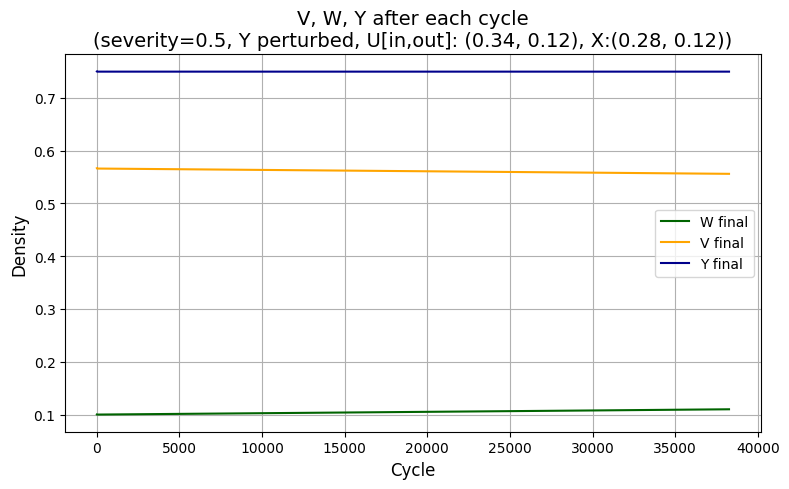

Saved run_invasion plot to run_invasion/run_invasion37.pdf


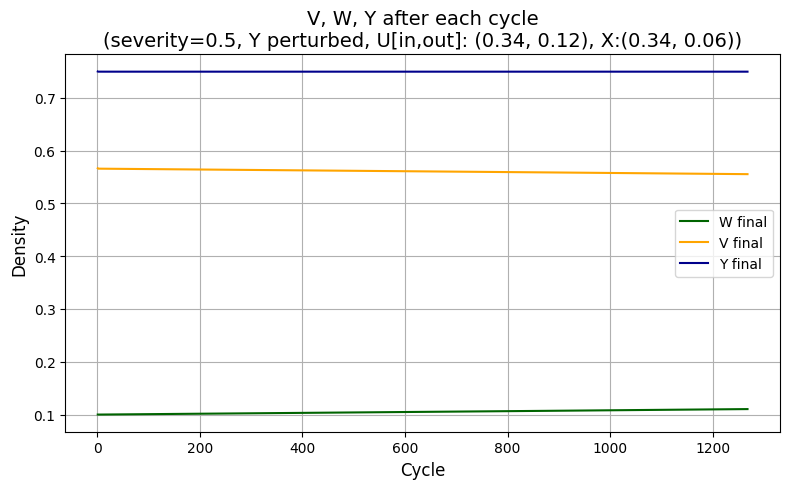

Saved run_invasion plot to run_invasion/run_invasion38.pdf


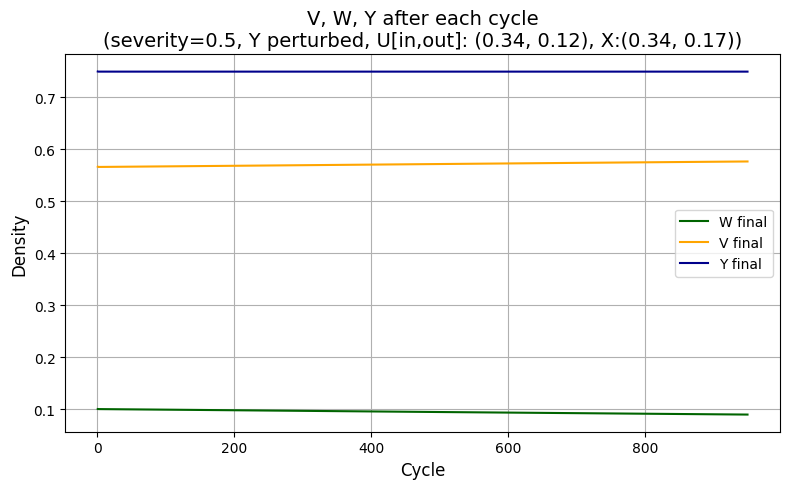

Saved run_invasion plot to run_invasion/run_invasion39.pdf


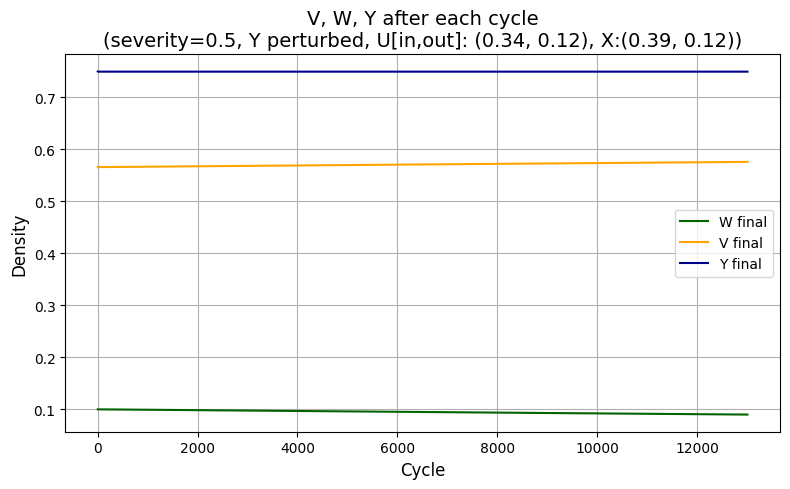

([(0.2822222222222222, 0.11888888888888888),
  (0.33666666666666667, 0.06444444444444444),
  (0.33666666666666667, 0.17333333333333334),
  (0.3911111111111111, 0.11888888888888888)],
 [0.33666666666666667, 0.11888888888888888])

In [18]:
cycles = 50000
extinction_rate = 100

test_invasion(
    x[0], x[1], x[3], (i0, j0),
    V0, W0, Y0,
    W_birth, Y_birth, W_death, Y_death,
    Z_in, Z_out,
    extinction_rate, dt,
    use_X, use_Z,
    cycles, severity,
)